# Process Capture Set

This notebook iterates through a given folder and processes all of the datacubes in it. The first block processes them to level 4, binned wavelengths, the second processes them to level 6, full reflectance.


This notebook requires that a radiative transfer calibration has been completed prior.


In [13]:
from datetime import datetime
from openhsi.atmos import *
from openhsi.capture import *
from Py6S import *
from scipy.interpolate import interp1d
import numpy as np
import netCDF4 as nc
import pickle as pk
import os

## Setup

### Secondary Capture

In [14]:
# path to the recorded image
data_path = "data/secondary-captures/wet/2022_11_08"
raw_processed_path = "processed-data/secondary-capture"
processed_processed_path = raw_processed_path + "/reflectance"

# original camera settings
json_path = "assets/OpenHSI-11_settings_Mono12_bin2.json"
pkl_path  = "assets/OpenHSI-11_calibration_Mono12_bin2_window.pkl"

# location/files to store updated camera settings in
updated_cam_settings_path = raw_processed_path + "/settings.json"
updated_cam_calibration_path = raw_processed_path + "/calibration.pkl"

# processing level to use
proc_lvl_1 = 4 # level to process the raw data to
proc_lvl_2 = 6 # level to process the processed data to

### Tertiary Capture

In [15]:
# path to the recorded image
data_path = "data/proportion-captures/2022_11_16/15ms-33-1st"
data_path = "data/proportion-captures/2022_11_16/15ms-33-2nd"
data_path = "data/proportion-captures/2022_11_16/15ms-seg-1st"
data_path = "data/proportion-captures/2022_11_16/15ms-seg-2nd"
raw_processed_path = "processed-data/tertiary-capture"
processed_processed_path = raw_processed_path + "/reflectance"

# original camera settings
json_path = "assets/OpenHSI-11_settings_Mono12_bin2.json"
pkl_path  = "assets/OpenHSI-11_calibration_Mono12_bin2_window.pkl"

# location/files to store updated camera settings in
updated_cam_settings_path = raw_processed_path + "/settings.json"
updated_cam_calibration_path = raw_processed_path + "/calibration.pkl"

# processing level to use
proc_lvl_1 = 4 # level to process the raw data to
proc_lvl_2 = 6 # level to process the processed data to

### Sardi Capture

In [16]:
# path to the recorded image
data_path = "data/captured-data-sardi-2/2023_02_28"

raw_processed_path = "processed-data/sardi-capture"
save_data_path = raw_processed_path + "/capture-2"
processed_path = save_data_path + "/radiance"
processed_processed_path = save_data_path + "/reflectance"

# original camera settings
json_path = "assets/OpenHSI-11_settings_Mono12_bin2.json"
pkl_path  = "assets/OpenHSI-11_calibration_Mono12_bin2_window.pkl"

# location/files to store updated camera settings in
updated_cam_settings_path = raw_processed_path + "/settings.json"
updated_cam_calibration_path = raw_processed_path + "/calibration.pkl"

# processing level to use
proc_lvl_1 = 4 # level to process the raw data to
proc_lvl_2 = 6 # level to process the processed data to

### Bedford Capture

In [17]:
# path to the recorded image
data_path = "data/captured-data-bedford-1/2023_03_14"

raw_processed_path = "processed-data/bedford-capture"
save_data_path = raw_processed_path + "/capture-2"
processed_path = save_data_path + "/radiance"
processed_processed_path = save_data_path + "/reflectance"

# original camera settings
json_path = "assets/OpenHSI-11_settings_Mono12_bin2.json"
pkl_path  = "assets/OpenHSI-11_calibration_Mono12_bin2_window.pkl"

# location/files to store updated camera settings in
updated_cam_settings_path = raw_processed_path + "/settings.json"
updated_cam_calibration_path = raw_processed_path + "/calibration.pkl"

# processing level to use
proc_lvl_1 = 4 # level to process the raw data to
proc_lvl_2 = 6 # level to process the processed data to

### Sardi Capture 2

In [18]:
# path to the recorded image
data_path = "data/sardi-final/2023_03_27"

raw_processed_path = "processed-data/sardi-capture"
save_data_path = raw_processed_path + "/final"
processed_path = save_data_path + "/radiance"
processed_processed_path = save_data_path + "/reflectance"

# original camera settings
json_path = "assets/OpenHSI-11_settings_Mono12_bin2.json"
pkl_path  = "assets/OpenHSI-11_calibration_Mono12_bin2_window.pkl"

# location/files to store updated camera settings in
updated_cam_settings_path = raw_processed_path + "/settings.json"
updated_cam_calibration_path = raw_processed_path + "/calibration.pkl"

# processing level to use
proc_lvl_1 = 4 # level to process the raw data to
proc_lvl_2 = 6 # level to process the processed data to

In [19]:
dir_cont = os.listdir(data_path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]
print(data_cubes)

['2023_03_27-23_57_45.nc']


Due to memory requirements I am batching the processessing of the secondary capture.

```
['2022_11_08-03_07_05.nc', '2022_11_08-03_05_38.nc', '2022_11_08-02_35_55.nc', '2022_11_08-02_29_59.nc', '2022_11_08-02_27_29.nc', '2022_11_08-02_56_33.nc', '2022_11_08-02_34_13.nc', '2022_11_08-02_57_06.nc', '2022_11_08-02_55_33.nc', '2022_11_08-02_36_42.nc', '2022_11_08-03_02_28.nc', '2022_11_08-02_54_47.nc', '2022_11_08-03_01_21.nc', '2022_11_08-02_29_19.nc', '2022_11_08-03_00_10.nc', '2022_11_08-02_37_58.nc', '2022_11_08-02_59_16.nc', '2022_11_08-02_54_09.nc', '2022_11_08-02_30_36.nc', '2022_11_08-02_47_05.nc', '2022_11_08-03_06_08.nc', '2022_11_08-03_04_29.nc', '2022_11_08-02_28_28.nc', '2022_11_08-02_49_58.nc', '2022_11_08-02_49_26.nc', '2022_11_08-02_48_52.nc', '2022_11_08-02_48_17.nc', '2022_11_08-03_01_52.nc', '2022_11_08-02_37_15.nc', '2022_11_08-03_05_09.nc']
```

The above is the full array, I am going to batch them in sets of 5.

The tertiary capture is in units of 10 images so shouldn't need batching. It does, doing 5 at a time again.
```
# 33% 10cm water
['2022_11_16-03_40_19.nc', '2022_11_16-03_36_39.nc', '2022_11_16-03_34_42.nc', '2022_11_16-03_37_53.nc', '2022_11_16-03_42_45.nc', '2022_11_16-03_43_20.nc', '2022_11_16-03_41_33.nc', '2022_11_16-03_38_55.nc', '2022_11_16-03_38_24.nc', '2022_11_16-03_35_33.nc']

# 33% 20cm water
['2022_11_16-04_01_51.nc', '2022_11_16-04_11_30.nc', '2022_11_16-04_10_05.nc', '2022_11_16-04_13_22.nc', '2022_11_16-04_03_31.nc', '2022_11_16-04_12_37.nc', '2022_11_16-04_04_28.nc', '2022_11_16-04_02_46.nc', '2022_11_16-04_08_52.nc', '2022_11_16-04_10_54.nc']

# segmentation 10cm water
['2022_11_16-03_20_48.nc', '2022_11_16-03_16_55.nc', '2022_11_16-03_23_02.nc', '2022_11_16-03_22_07.nc', '2022_11_16-03_23_39.nc', '2022_11_16-03_16_13.nc', '2022_11_16-03_27_12.nc', '2022_11_16-03_18_55.nc', '2022_11_16-03_21_22.nc', '2022_11_16-03_15_07.nc']

# segmentation 20cm water
['2022_11_16-04_21_31.nc', '2022_11_16-04_26_19.nc', '2022_11_16-04_23_06.nc', '2022_11_16-04_19_38.nc', '2022_11_16-04_23_42.nc', '2022_11_16-04_30_44.nc', '2022_11_16-04_30_07.nc', '2022_11_16-04_27_46.nc', '2022_11_16-04_28_59.nc', '2022_11_16-04_25_37.nc']

```

SARDI Data 1

```
['2023_02_27-01_49_30.nc', '2023_02_27-03_12_50.nc', '2023_02_27-01_47_38.nc', '2023_02_27-01_43_22.nc', '2023_02_27-01_41_25.nc', '2023_02_27-01_34_57.nc', '2023_02_27-02_57_52.nc', '2023_02_27-02_52_59.nc', '2023_02_27-01_51_25.nc', '2023_02_27-03_01_37.nc', '2023_02_27-01_53_44.nc', '2023_02_27-03_10_29.nc', '2023_02_27-03_18_41.nc', '2023_02_27-01_37_17.nc', '2023_02_27-03_08_06.nc', '2023_02_27-03_04_48.nc', '2023_02_27-01_45_23.nc', '2023_02_27-01_39_24.nc', '2023_02_27-03_16_13.nc', '2023_02_27-02_55_25.nc']
```

SARDI Data 2

There were two subfolders so I ran this twice and added the outputs together.

```
['2023_02_27-23_55_14.nc', '2023_02_27-23_59_39.nc', '2023_02_27-23_43_58.nc', '2023_02_27-23_57_20.nc', '2023_02_27-23_41_47.nc', '2023_02_27-23_52_55.nc']

['2023_02_28-00_35_45.nc', '2023_02_28-00_08_16.nc', '2023_02_28-00_31_06.nc', '2023_02_28-00_15_10.nc', '2023_02_28-00_23_06.nc', '2023_02_28-00_38_57.nc', '2023_02_28-00_02_32.nc', '2023_02_28-00_13_11.nc', '2023_02_28-00_33_31.nc', '2023_02_28-00_17_51.nc', '2023_02_28-00_29_01.nc', '2023_02_28-00_26_58.nc', '2023_02_28-00_10_53.nc', '2023_02_28-00_06_04.nc']
```

SARDI Data 3

```
['2023_02_28-01_03_28.nc', '2023_02_28-01_24_20.nc', '2023_02_28-01_34_24.nc', '2023_02_28-01_30_04.nc', '2023_02_28-01_14_55.nc', '2023_02_28-01_47_08.nc', '2023_02_28-01_27_14.nc', '2023_02_28-01_00_28.nc', '2023_02_28-01_06_05.nc', '2023_02_28-01_20_08.nc', '2023_02_28-01_38_44.nc', '2023_02_28-01_36_48.nc', '2023_02_28-01_18_13.nc', '2023_02_28-01_40_40.nc', '2023_02_28-01_22_01.nc', '2023_02_28-01_32_04.nc', '2023_02_28-01_12_55.nc', '2023_02_28-01_45_10.nc', '2023_02_28-01_43_06.nc', '2023_02_28-01_49_04.nc']

```

Bedford Capture 1

```
['2023_03_14-01_55_01.nc', '2023_03_14-01_51_20.nc', '2023_03_14-02_01_40.nc', '2023_03_14-01_40_47.nc', '2023_03_14-01_42_06.nc', '2023_03_14-02_05_38.nc', '2023_03_14-02_03_31.nc', '2023_03_14-01_49_45.nc', '2023_03_14-01_56_42.nc', '2023_03_14-01_53_14.nc', '2023_03_14-01_44_34.nc', '2023_03_14-01_48_23.nc', '2023_03_14-01_58_25.nc', '2023_03_14-01_39_32.nc', '2023_03_14-02_08_44.nc', '2023_03_14-01_46_01.nc', '2023_03_14-02_00_05.nc', '2023_03_14-01_26_05.nc', '2023_03_14-01_43_21.nc', '2023_03_14-02_07_19.nc']
```

Bedford Capture 2

```
['2023_03_14-02_49_05.nc', '2023_03_14-02_57_53.nc', '2023_03_14-02_46_28.nc', '2023_03_14-02_44_33.nc', '2023_03_14-02_56_11.nc', '2023_03_14-02_39_26.nc', '2023_03_14-02_53_36.nc', '2023_03_14-02_41_27.nc', '2023_03_14-02_51_48.nc', '2023_03_14-02_42_51.nc']
```

In [21]:
# For batching...
data_cubes = ['2023_03_27-23_57_45.nc']

for file in data_cubes:
    path = data_path + '/' + file
    
    # read unprocessed data into openhsi
    proc_dc = ProcessRawDatacube(fname = path, processing_lvl=proc_lvl_1,
                                 json_path=json_path, pkl_path=pkl_path)

    # 'collect' the data (read reprocess)
    proc_dc.collect()

    # print the datacube to check processing level
    print(proc_dc)

    # save the now processed image
    proc_dc.save(processed_path)
    
    del(proc_dc)

Allocated 964.38 MB of RAM.


KeyError: "no index found for coordinate 'exposure'"

### Complete processing of processed data

You will need to input the updated `raw_processed_path` with the file in here.

In [11]:
# The following did not work for the secondary captures
# proc_data_path = raw_processed_path + '/' + data_path.split('/')[len(data_path.split('/'))-1]

proc_data_path = "processed-data/bedford-capture/capture-2/radiance/2023_03_14"

In [12]:
dir_cont = os.listdir(proc_data_path)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]
print(data_cubes)

['2023_03_14-02_49_05.nc', '2023_03_14-02_57_53.nc', '2023_03_14-02_46_28.nc', '2023_03_14-02_44_33.nc', '2023_03_14-02_56_11.nc', '2023_03_14-02_39_26.nc', '2023_03_14-02_53_36.nc', '2023_03_14-02_41_27.nc', '2023_03_14-02_51_48.nc', '2023_03_14-02_42_51.nc']


Again, I will be batching the secondary capture, here are the files:

```
# Secondary Capture
['2022_11_08-03_07_05.nc', '2022_11_08-03_05_38.nc', '2022_11_08-02_35_55.nc', '2022_11_08-02_29_59.nc', '2022_11_08-02_27_29.nc', '2022_11_08-02_56_33.nc', '2022_11_08-02_34_13.nc', '2022_11_08-02_57_06.nc', '2022_11_08-02_55_33.nc', '2022_11_08-02_36_42.nc', '2022_11_08-03_02_28.nc', '2022_11_08-02_54_47.nc', '2022_11_08-03_01_21.nc', '2022_11_08-02_29_19.nc', '2022_11_08-03_00_10.nc', '2022_11_08-02_37_58.nc', '2022_11_08-02_59_16.nc', '2022_11_08-02_54_09.nc', '2022_11_08-02_30_36.nc', '2022_11_08-02_47_05.nc', '2022_11_08-03_06_08.nc', '2022_11_08-03_04_29.nc', '2022_11_08-02_28_28.nc', '2022_11_08-02_49_58.nc', '2022_11_08-02_49_26.nc', '2022_11_08-02_48_52.nc', '2022_11_08-02_48_17.nc', '2022_11_08-03_01_52.nc', '2022_11_08-02_37_15.nc', '2022_11_08-03_05_09.nc']
```
And the tertiary catpure

```
# Tertiary Capture
['2022_11_16-04_21_31.nc', '2022_11_16-04_26_19.nc', '2022_11_16-03_40_19.nc', '2022_11_16-04_23_06.nc', '2022_11_16-04_01_51.nc', '2022_11_16-03_36_39.nc', '2022_11_16-04_11_30.nc', '2022_11_16-03_20_48.nc', '2022_11_16-04_19_38.nc', '2022_11_16-03_34_42.nc', '2022_11_16-03_37_53.nc', '2022_11_16-04_23_42.nc', '2022_11_16-04_30_44.nc', '2022_11_16-03_42_45.nc', '2022_11_16-04_10_05.nc', '2022_11_16-03_16_55.nc', '2022_11_16-04_13_22.nc', '2022_11_16-03_43_20.nc', '2022_11_16-03_41_33.nc', '2022_11_16-04_03_31.nc', '2022_11_16-03_38_55.nc', '2022_11_16-03_23_02.nc', '2022_11_16-04_12_37.nc', '2022_11_16-04_30_07.nc', '2022_11_16-04_04_28.nc', '2022_11_16-04_27_46.nc', '2022_11_16-03_22_07.nc', '2022_11_16-03_38_24.nc', '2022_11_16-03_23_39.nc', '2022_11_16-04_02_46.nc', '2022_11_16-04_28_59.nc', '2022_11_16-03_35_33.nc', '2022_11_16-03_16_13.nc', '2022_11_16-03_27_12.nc', '2022_11_16-04_08_52.nc', '2022_11_16-04_25_37.nc', '2022_11_16-03_18_55.nc', '2022_11_16-04_10_54.nc', '2022_11_16-03_21_22.nc', '2022_11_16-03_15_07.nc']
```

And SARDI capture 1

```
['2023_02_27-01_49_30.nc', '2023_02_27-03_12_50.nc', '2023_02_27-01_47_38.nc', '2023_02_27-01_43_22.nc', '2023_02_27-01_41_25.nc', '2023_02_27-01_34_57.nc', '2023_02_27-02_57_52.nc', '2023_02_27-02_52_59.nc', '2023_02_27-01_51_25.nc', '2023_02_27-03_01_37.nc', '2023_02_27-01_53_44.nc', '2023_02_27-03_10_29.nc', '2023_02_27-03_18_41.nc', '2023_02_27-01_37_17.nc', '2023_02_27-03_08_06.nc', '2023_02_27-03_04_48.nc', '2023_02_27-01_45_23.nc', '2023_02_27-01_39_24.nc', '2023_02_27-03_16_13.nc', '2023_02_27-02_55_25.nc']
```

SARDI capture 2

```
['2023_02_27-23_55_14.nc', '2023_02_27-23_59_39.nc', '2023_02_27-23_43_58.nc', '2023_02_27-23_57_20.nc', '2023_02_27-23_41_47.nc', '2023_02_27-23_52_55.nc']

['2023_02_28-00_35_45.nc', '2023_02_28-00_08_16.nc', '2023_02_28-00_31_06.nc', '2023_02_28-00_15_10.nc', '2023_02_28-00_23_06.nc', '2023_02_28-00_38_57.nc', '2023_02_28-00_02_32.nc', '2023_02_28-00_13_11.nc', '2023_02_28-00_33_31.nc', '2023_02_28-00_17_51.nc', '2023_02_28-00_29_01.nc', '2023_02_28-00_26_58.nc', '2023_02_28-00_10_53.nc', '2023_02_28-00_06_04.nc']
```

SARDI capture 3

```
['2023_02_28-01_03_28.nc', '2023_02_28-01_24_20.nc', '2023_02_28-01_34_24.nc', '2023_02_28-01_30_04.nc', '2023_02_28-01_14_55.nc', '2023_02_28-01_47_08.nc', '2023_02_28-01_27_14.nc', '2023_02_28-01_00_28.nc', '2023_02_28-01_06_05.nc', '2023_02_28-01_20_08.nc', '2023_02_28-01_38_44.nc', '2023_02_28-01_36_48.nc', '2023_02_28-01_18_13.nc', '2023_02_28-01_40_40.nc', '2023_02_28-01_22_01.nc', '2023_02_28-01_32_04.nc', '2023_02_28-01_12_55.nc', '2023_02_28-01_45_10.nc', '2023_02_28-01_43_06.nc', '2023_02_28-01_49_04.nc']
```

Bedford Capture 1

```
['2023_03_14-01_55_01.nc', '2023_03_14-01_51_20.nc', '2023_03_14-02_01_40.nc', '2023_03_14-01_40_47.nc', '2023_03_14-01_42_06.nc', '2023_03_14-02_05_38.nc', '2023_03_14-02_03_31.nc', '2023_03_14-01_49_45.nc', '2023_03_14-01_56_42.nc', '2023_03_14-01_53_14.nc', '2023_03_14-01_44_34.nc', '2023_03_14-01_48_23.nc', '2023_03_14-01_58_25.nc', '2023_03_14-01_39_32.nc', '2023_03_14-02_08_44.nc', '2023_03_14-01_46_01.nc', '2023_03_14-02_00_05.nc', '2023_03_14-01_26_05.nc', '2023_03_14-01_43_21.nc', '2023_03_14-02_07_19.nc']
```

Bedford Capture 2

```
['2023_03_14-02_49_05.nc', '2023_03_14-02_57_53.nc', '2023_03_14-02_46_28.nc', '2023_03_14-02_44_33.nc', '2023_03_14-02_56_11.nc', '2023_03_14-02_39_26.nc', '2023_03_14-02_53_36.nc', '2023_03_14-02_41_27.nc', '2023_03_14-02_51_48.nc', '2023_03_14-02_42_51.nc']
```

Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 861.38it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 796.57it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 965.14it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 1177.88it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 976.20it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 703.76it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 792.01it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 1101.14it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 783.07it/s]


Allocated 142.60 MB of RAM.
Allocated 142.60 MB of RAM.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 650/650 [00:00<00:00, 986.80it/s]


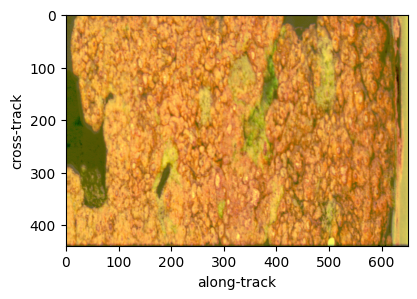

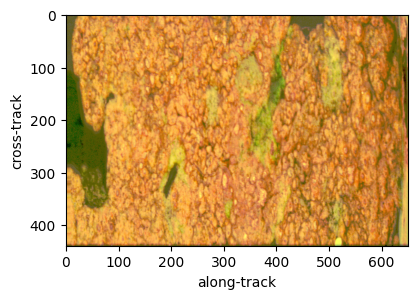

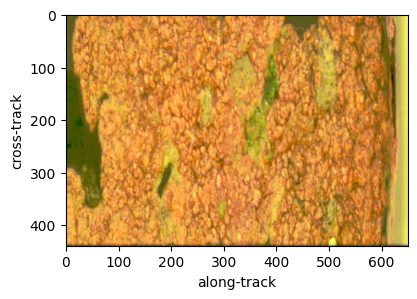

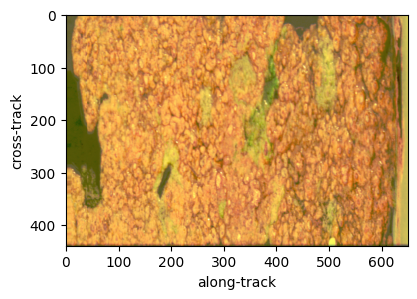

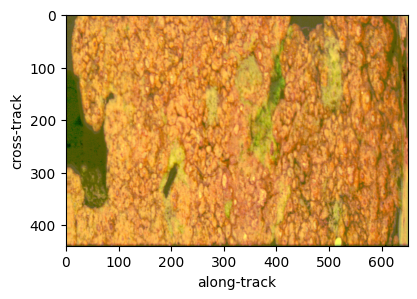

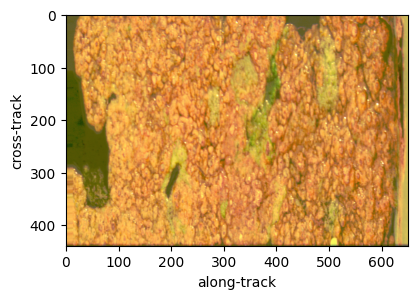

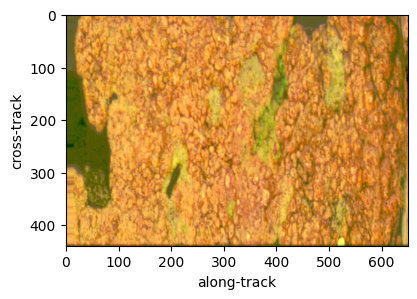

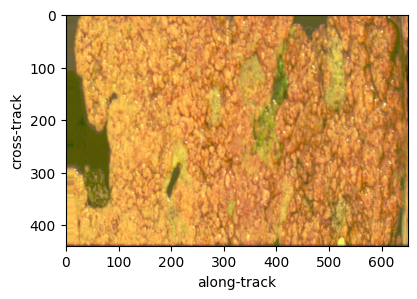

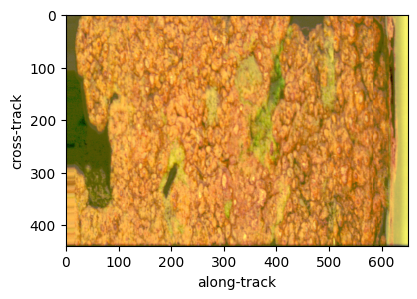

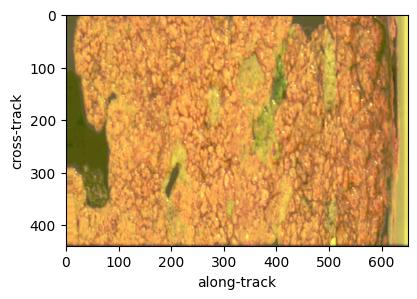

In [13]:
# for batching...
# data_cubes = ['2023_03_14-01_55_01.nc', '2023_03_14-01_51_20.nc', '2023_03_14-02_01_40.nc', '2023_03_14-01_40_47.nc', '2023_03_14-01_42_06.nc', '2023_03_14-02_05_38.nc', '2023_03_14-02_03_31.nc', '2023_03_14-01_49_45.nc', '2023_03_14-01_56_42.nc', '2023_03_14-01_53_14.nc']

for fname in data_cubes:
    proced_dc = ProcessDatacube(fname = proc_data_path + '/' + fname, processing_lvl=proc_lvl_2,
                                 json_path=updated_cam_settings_path, pkl_path=updated_cam_calibration_path)

    # specifically define that the transform should be from radiance to reflectance.
    proced_dc.load_next_tfms([proced_dc.rad2ref_6SV])

    proced_dc.collect()
    
    proced_dc.save(processed_processed_path)